# Outlier Detection with SVM
This notebook is based on a blog post by James Stradling from ThisData (https://thisdata.com/blog/unsupervised-machine-learning-with-one-class-support-vector-machines/)

Data: data/kddcup.data_10_percent_corrected

This notebook is different from that linked above due to source data file changes.
### Load the raw log data

In [50]:
%matplotlib inline

import numpy as np  
import pandas as pd  
from sklearn import utils  
import matplotlib.pyplot as plt

# import the CSV from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# this will return a pandas dataframe.
data = pd.read_csv('data/kddcup.data_10_percent_corrected.csv', low_memory=False, header=None)

### Load the column headings from the associated text file

In [51]:
with open('data/kddcup.names.txt') as f:
    content = f.readlines()
    print(content)

['back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.\n', 'duration: continuous.\n', 'protocol_type: symbolic.\n', 'service: symbolic.\n', 'flag: symbolic.\n', 'src_bytes: continuous.\n', 'dst_bytes: continuous.\n', 'land: symbolic.\n', 'wrong_fragment: continuous.\n', 'urgent: continuous.\n', 'hot: continuous.\n', 'num_failed_logins: continuous.\n', 'logged_in: symbolic.\n', 'num_compromised: continuous.\n', 'root_shell: continuous.\n', 'su_attempted: continuous.\n', 'num_root: continuous.\n', 'num_file_creations: continuous.\n', 'num_shells: continuous.\n', 'num_access_files: continuous.\n', 'num_outbound_cmds: continuous.\n', 'is_host_login: symbolic.\n', 'is_guest_login: symbolic.\n', 'count: continuous.\n', 'srv_count: continuous.\n', 'serror_rate: continuous.\n', 'srv_serror_rate: continuous.\n', 'rerror_rate: continuous.\n', 'srv_rerror_rate: continu

### Filter the values to just the column names

In [52]:
col_names = [x[0:x.index(':')] for x in content if x.find(':') > 1]
print(col_names)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


### Set the column names of the dataframe including a label column

In [53]:
col_names.append('label')
data.columns = col_names
data.head(1)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.


### Filter the dataframe to web requests where the user is logged in and plot the value counts for the label

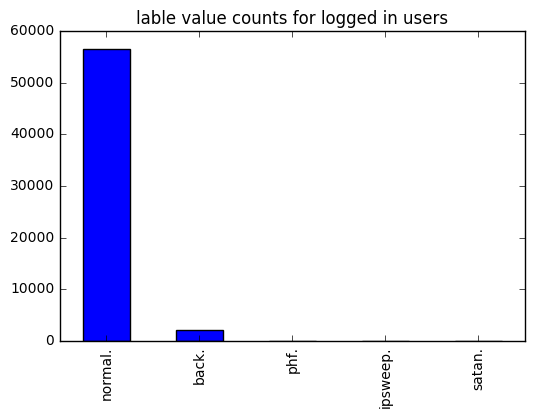

In [54]:
# extract just the logged-in HTTP accesses from the data
df = data[(data['service'] == "http") & (data["logged_in"] == 1)]
# data = data[data["logged_in"] == 1]

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.set_title('lable value counts for logged in users')
# let's take a look at the types of attack labels are present in the data.
df['label'].value_counts().plot(kind='bar') 
plt.show()

### Filter the dataframe to the features we want to train our model

In [55]:
relevant_features = [  
    "duration",
    "src_bytes",
    "dst_bytes",
    "label"
]
df_filtered = df[relevant_features]
df_filtered.head()

,duration,src_bytes,dst_bytes,label
0,0,181,5450,normal.
1,0,239,486,normal.
2,0,235,1337,normal.
3,0,219,1337,normal.
4,0,217,2032,normal.


### Normalise the values to suite the algorithm

In [56]:
# normalise the data - this leads to better accuracy and reduces numerical instability in
# the SVM implementation
df_filtered["duration"] = np.log((df_filtered["duration"] + 0.1).astype(float))  
df_filtered["src_bytes"] = np.log((df_filtered["src_bytes"] + 0.1).astype(float))  
df_filtered["dst_bytes"] = np.log((df_filtered["dst_bytes"] + 0.1).astype(float)) 

/Volumes/ThorsHammer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Volumes/ThorsHammer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Volumes/ThorsHammer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [57]:
df_filtered.head()

,duration,src_bytes,dst_bytes,label
0,-2.302585,5.199049,8.603389,normal.
1,-2.302585,5.476882,6.186414,normal.
2,-2.302585,5.460011,7.198258,normal.
3,-2.302585,5.389528,7.198258,normal.
4,-2.302585,5.380358,7.616825,normal.


### Investigate the ratio of attack/normal observations and drop the label for training
This ratio will be useful later when specifying training parameters for the SVM algorithm.

In [58]:
# we're using a one-class SVM, so we need.. a single class. the dataset label, 'Response'
# column contains multiple different categories of attacks, so to make use of 
# this data in a one-class system we need to convert the attacks into
# class 1 (normal) and class -1 (attack)
df_filtered.loc[df_filtered['label'] == "normal.", "attack"] = 1  
df_filtered.loc[df_filtered['label'] != "normal.", "attack"] = -1

# grab out the attack value as the target for training and testing. since we're
# only selecting a single column from the `data` dataframe, we'll just get a
# series, not a new dataframe
target = df_filtered['attack']

# find the proportion of outliers we expect (aka where `attack == -1`). because 
# target is a series, we just compare against itself rather than a column.
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", float(outliers.shape[0])/target.shape[0])

# drop label columns from the dataframe. we're doing this so we can do 
# unsupervised training with unlabelled data. we've already copied the label
# out into the target series so we can compare against it later.
df_filtered.drop(["label", "attack"], axis=1, inplace=True)

# check the shape for sanity checking.
df_filtered.shape  

('outliers.shape', (2209,))
('outlier fraction', 0.03761600681140911)


/Volumes/ThorsHammer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(58725, 3)

### Split the data into training and test datasets

In [59]:
from sklearn.model_selection import train_test_split  
train_data, test_data, train_target, test_target = train_test_split(df_filtered, target, train_size = 0.8, random_state=1)  
train_data.shape 

(46980, 3)

### Train the model

In [60]:
from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = float(outliers.shape[0]) / target.shape[0]  
print("nu", nu)

model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005, random_state=0)  
model.fit(train_data)

('nu', 0.03761600681140911)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.0376160068114, random_state=0, shrinking=True,
      tol=0.001, verbose=False)

### Report the trained model metrics for evaluation

In [61]:
from sklearn import metrics  
preds = model.predict(train_data)  
targs = train_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

('accuracy: ', 0.9772243507875692)
('precision: ', 0.9987570059663714)
('recall: ', 0.97754822155370735)
('f1: ', 0.9880388123770345)
('area under curve (auc): ', 0.97325492341793718)


### Save the model to disk for use in production

In [62]:
outputfile = 'oneclass_v1.model'  
from sklearn.externals import joblib  
joblib.dump(model, outputfile, compress=9)  

['oneclass_v1.model']